$
\newcommand{\xv}{\mathbf{x}}
\newcommand{\wv}{\mathbf{w}}
$

# Decision Tree

So far, we have examined parameteric methods--from the given input and output, we learn the parameters that map between them with minimum loss. Decision tree is a good example for *nonparametric* method. A decition tree is a hierarchical data structure that implements the divide-and-conquer strategy (see the picture below). This can be efficiently applied to both classification and regression problems. 

![](https://upload.wikimedia.org/wikipedia/commons/c/c6/Manual_decision_tree.jpg)
<center> wikipedia </center>

Mimicing the human decision logics, the decision tree recursively splits data into local regions. It is composed of decision nodes and terminal leaves. On each decision node, it finds a *test* function with a split threshold and the test function will outcome the branches. Starting from the root, if we traverse recursively to the leaf, we can reach the output label. 


## Practice 

**TODO:** Find a rule (if-statement) for the following classification boundaries (from Kdnuggets data mining course by Piatetsky and Parker) and write down your psedo code for it.  

![](https://webpages.uncc.edu/mlee173/teach/itcs4156online/images/class/decision_tree.png)









## Univariate Trees

In each decision node, when the test function uses only one input feature, we call it as univariate tree. Let $x_k$ bs a $k$-th input dimension in a decision node $m$. If $x_k$ is discrete (ie. {red, green, blue}), the test function will output the corresponding branches to split (ie. three branches). If $x_k$ is continuous, we will need to choose threshold values $\theta_m$ to build a test function

$$
  f_m(\xv): x_k > \theta_m,
$$
which will result in binary split. As we practiced above, the leaf nodes will form a hyperrectangles for classificaiton. 

Then, how can we build those three is the question that we have for a learning problem.
There can be multiple trees even with zero errors. One of simple choice that we can make is the tree with lowest complexity (ie. with the smallest number of nodes). Finding the smallest tree is NP-complete (Quinlan 1986), so we use local search based on heuristics. 

The greedy learning algorithm can be outlined as

1. find a feature for decision making
2. find a split threshold for the test condition
3. check stopping criteria
4. create children and recursively repeat 1-4. 

Here the stopping condition can be when we cannot split anymore, which means a leaf node is created and labeled. 



## Classification Trees

Let us focus the application of decision trees on classification problems. For learning, we need to consider how we can select a feature or a threshold for a decision node. For this, we need to measure the goodness of a split, which is called *impurity measure*. 
Here summarizes the popular impurity measures. 

1. Misclassification Rate
$$
E_R = \frac{| \{i: y_i^R \ne t_i, x_i \in R \} | }{|\{ i: x_i \in R \}| }
$$
2. Information Gain (Cross-entropy)
$$
I = -\sum_{i=1}^N p_i \log_2 p_i \\
I_G = I_{parent} - I_{children} 
$$
3. Gini Impurity (Breiman et al. 1984)
$$
I_G = \sum_{i=1}^N p_i (1 - p_i) = \sum_{i=1}^N p_i - \sum_{i=1}^N p_i^2 = 1 - \sum_{i=1}^N p_i^2
$$




In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(35, 2)

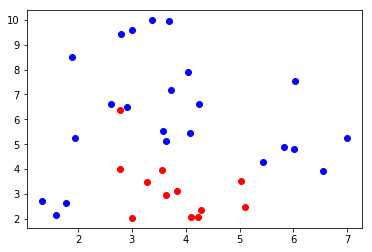

In [2]:
# test data similar to the practice

# 25 data samples from X1 - X3
X1 = np.random.rand(7,2) * 2
X1[:, 0] += 5 
X1[:, 1] = X1[:, 1] * 3 + 2 

X2 = np.random.rand(15,2) * 5 
X2[:, 1] += 5 

X3 = np.random.rand(3,2) + 1 
X3[:, 1] += 1 

# 10 data samples for X4
X4 = np.random.rand(10,2) * 3
X4[:, 0] += 2.5 
X4[:, 1] += 2 

# input data  
X = np.vstack((X1, X2, X3, X4))

# target label
T = np.zeros(35)
T[25:] = 1
# pick randomly from X1 and X2 as different class for noise 
T[[5, 15]] = 1


plt.plot(X[T==0,0], X[T==0,1], 'bo')
plt.plot(X[T==1,0], X[T==1,1], 'ro')

X.shape

For the sample data, we first create function to compute the impurity measure.

In [71]:
# compute cross entropy
def entropy(t):
    _, c = np.unique(t, return_counts=True)
    probs = c / len(t)
    res = 0. 
    for p in probs:
        res += -p * np.log2(p)
    return res


# information gain for given cut at the index, k 
def info_gain(t, k):
    if k == 0 or k == len(t):
        return 0.
    
    Ip = entropy(t) # parent
    Icl = entropy(t[:k])  # left
    Icr = entropy(t[k:])  # right
    
    p_l = len(t[:k]) / len(t)
    p_r = 1 - p_l
    return Ip - p_l * Icl - p_r * Icr

# increasing threshold cut, compute the measures...
def impurity(t):
    return [info_gain(t, k) for k in range(1,len(t))]
        

Using the impurity measure, recursively find split parent into child to construct a tree.

In [72]:
eps = 1e-4

# find threshold and its impurity measure
def find_thres(x, t):
    best = None
    sorted_i = np.argsort(x)
    values = impurity(t[sorted_i])
    k = np.argmax(values)
    thres = np.mean(x[sorted_i][k:k+2])
    return (thres, values[k])

def split(X, t, root=0, max_depth=4):
    if root / 2 >= max_depth:
        return
    
    # when there is only one element in the target, stop 
    if len(np.unique(t)) == 1:
        return t
    
    # 1. find a feature for decision making
    measures = np.max([impurity(t[np.argsort(X[:, j])]) for j in range(X.shape[1])], 1)
    j = np.argmax(measures)
    
    # if max is close to zero, return 
    if measures[j] < eps:
        return t
    
    # 2. find a split threshold for the test condition
    best_thres, best_val = find_thres(X[:, j], t) 
    
    # assuming binary tree
    left = X[:,j] < best_thres
    right = X[:,j] >= best_thres
    
    # BUILD A TREE STRUCTURE HERE
    res = {}
    res[(root, "L", j, best_thres)] = split(X[left], t[left], 2 * root + 1, max_depth)
    res[(root, "R", j, best_thres)] = split(X[right], t[right], 2 * root + 2, max_depth)

    return res

Training the decision tree on the data, we achive the tree as shown in the output. 

In [73]:
tree = split(X, T, 0, 2)
tree

{(0,
  'L',
  1,
  4.1370699786970038): {(1,
   'L',
   0,
   2.2755893533553113): array([ 0.,  0.,  0.]), (1,
   'R',
   0,
   2.2755893533553113): None},
 (0, 'R', 1, 4.1370699786970038): {(2, 'L', 0, 2.7885215231257345): None,
  (2, 'R', 0, 2.7885215231257345): None}}

Recursively traversing the tree, we plot the data and decision boundary. 

[(0, 'L', 1, 4.1370699786970038), (0, 'R', 1, 4.1370699786970038)]
[(1, 'L', 0, 2.2755893533553113), (1, 'R', 0, 2.2755893533553113)]
[(2, 'L', 0, 2.7885215231257345), (2, 'R', 0, 2.7885215231257345)]


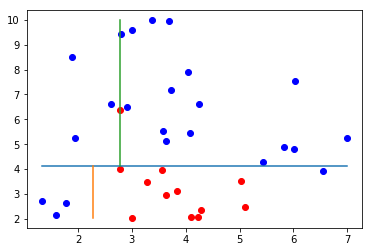

In [69]:
plt.plot(X[T==0,0], X[T==0,1], 'bo')
plt.plot(X[T==1,0], X[T==1,1], 'ro')

xmin, xmax = np.min(X[:, 0]), np.max(X[:, 0])
ymin, ymax = np.min(X[:, 1]), np.max(X[:, 1])

def traverse(tr, xmin, xmax, ymin, ymax):
    if not isinstance(tr, dict):
        return
    
    keys = list(tr.keys())
    print(keys)
    _, _, j, thres = keys[0]
    if j == 1:
        #print(f"plot y {thres} {xmin} {xmax} {ymin} {ymax}")
        plt.plot([xmin, xmax], [thres, thres], '-')
        traverse(tr[keys[0]], xmin, xmax, ymin, thres) # left
        traverse(tr[keys[1]], xmin, xmax, thres, ymax) # right
    elif j == 0:
        #print(f"plot x {thres} {xmin} {xmax} {ymin} {ymax}")
        plt.plot([thres, thres], [ymin, ymax], '-')
        traverse(tr[keys[0]], xmin, thres, ymin, ymax) # left
        traverse(tr[keys[1]], thres, xmax, ymin, ymax) # right
    
        
traverse(tree, xmin, xmax, ymin, ymax)
    

 
## Regression Trees

A regression tree can be constructed in the same manner as a classification tree.
However, for regression trees, we need to modify the impurity measure appropriate for regression problems. We can simply replace previous information gain to standard deviation reduction and build a regression tree as in the scikit-learn figure.
When constructing a tree, we calculate the final value on a leaf note with the *average*. 
For example, please take a look at this (http://chem-eng.utoronto.ca/~datamining/dmc/decision_tree_reg.htm).

* Standard Deviation Reduction:
$$
\sigma_R = \sigma_{parent} - \sigma_{children}
$$


![](http://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png)


## Multivariate Trees

For a univariate tree, we use only one feature variable at each decision node for a split. In a multivarate tree, all the input features can be used. Thus, this becomes more general approach and the decision function can be defined as a linear function with a threshold $\tau_m$ at the node $m$ as
$$
b_m(\xv) = \wv_m^\top \xv - \tau_m> 0. 
$$

Because of an exhaustive search for vast amount of possible hyperplanes, it requires heavy computation (Murthy et al. 1994). 

## Random Forest

Random forest is an ensemble method that uses multiple trees (a bag of trees) for better classification or regression. With training data, it training a preset number of trees and when making a prediction, it votes for final decision from multiple decision tree predictions.
Typically, we refer to a decision forest in general and random forest when we training each tree with a random subset of the input features--this has increased overall accuracy significantly. 

![](https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12859-017-1578-z/MediaObjects/12859_2017_1578_Fig1_HTML.gif)

## References

[1] R. Quinlan, "Learning efficient classification procedures", Machine Learning: an artificial intelligence approach, Michalski, Carbonell & Mitchell (eds.), Morgan Kaufmann, 1983, p. 463-482.

[2] Quinlan, J. R. C4.5: Programs for Machine Learning. Morgan Kaufmann Publishers, 1993.

[3] Breiman, Leo; Friedman, J. H.; Olshen, R. A.; Stone, C. J. (1984). Classification and regression trees. Monterey, CA: Wadsworth & Brooks/Cole Advanced Books & Software.